# 1. All image csv

In [1]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # CSV header
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in sorted(os.listdir(image_folder)):
            # complete image file path
            image_path = os.path.join(image_folder, filename)

            # filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repository/FL/code/4_centralized_learning/csv_files/all_image.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/4_centralized_learning/csv_files/all_image.csv


# 2. Single hospital csv

In [2]:
import csv
import os
from collections import defaultdict

def filter_hospital_data(input_csv_path, target_hospital_ids):
    patient_data = defaultdict(list)

    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    hospital_55_data = []
    for images in patient_data.values():
        hospital_55_data.extend(images)

    return hospital_55_data

# Input and output paths
input_csv_path = '/local/data1/honzh073/local_repository/FL/code/4_centralized_learning/csv_files/all_image.csv'
output_folder = '/local/data1/honzh073/local_repository/FL/code/4_centralized_learning/csv_files'
# Single hospital id
target_hospital_ids = ['18','43','55']

# Get data for hospital 55
hospital_55_data = filter_hospital_data(input_csv_path, target_hospital_ids)

# Write hospital 55 data to CSV file
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

# Save hospital 55 data to 'hospital55.csv'
write_to_csv(os.path.join(output_folder, 'CL_data.csv'), hospital_55_data)

print("Saved single hospital csv.")


Saved single hospital csv.


# Functions

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
   
def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff



training class weight [0.6802469135802469, 1.8869863013698631]
Image location: /local/data1/honzh073/data/8bit_down224/patient_GVTGRCSQXJ_hospital_43_AFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_OKVPUZUWMW_hospital_55_NFF_image_5.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_OKVPUZUWMW_hospital_55_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_NRYSKVDBCE_hospital_18_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_LYPUSDSKDQ_hospital_55_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_XWVGPALIEE_hospital_18_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_TADAVBRLUJ_hospital_43_NFF_image_5.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_HIOOQPEKJC_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_WGYAOXELIO_hospital_55_NFF_image_4.png
Image loca

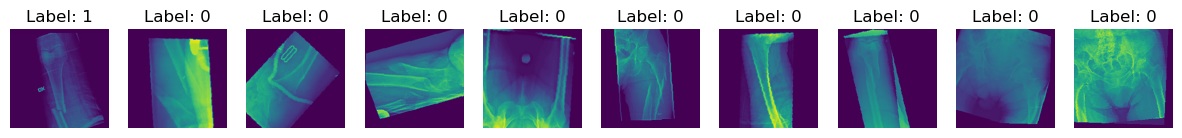

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 146, ratio: 0.26
----- NFF: 405, ratio: 0.74


In [4]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
from torchvision import transforms, models
from sklearn.model_selection import KFold

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations for training and testing
from torchvision import transforms

# augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),  # Random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random affine transformation (translation up to 10%)
    transforms.RandomResizedCrop(244, scale=(0.8, 1.0)),  # Random resized crop
    transforms.RandomAdjustSharpness(sharpness_factor=3),  # Random sharpness adjustment
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/4_centralized_learning/csv_files/CL_data.csv', transform=train_transform)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)


# print images
show_image(train_dataset, 5)

# calculate numbers
print("Saved train.csv")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# ------------------------------------------------------------------------------------------------------
def train_custom_model(model, train_dataset, num_epochs, batch_size, optimizer=None):
    classweight = get_classweight(train_dataset) # get_classweight is a function defined above
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):
        print(f'Fold {fold + 1}/{n_splits}')

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

        for epoch in range(num_epochs):
            model.train()
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100 * correct_train / total_train

            model.eval()
            correct_validation = 0
            total_validation = 0
            validation_loss = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total_validation += labels.size(0)
                    correct_validation += (predicted == labels).sum().item()
                    validation_loss += loss.item()

            validation_accuracy = 100 * correct_validation / total_validation
            validation_loss /= len(val_loader)

            print(f"Epoch {epoch+1}/{num_epochs}, "
                f"train ACC: {train_accuracy:.2f}%, "
                f"Val ACC: {validation_accuracy:.2f}%")
    return model  # Return the trained model after training is complete
# ------------------------------------------------------------------------------------------------------
def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()

    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    # Check if total_aff is zero before performing the division
    test_accuracy_nff = 100 * (correct_test_nff / total_nff) if total_nff != 0 else 0
    test_accuracy_aff = 100 * (correct_test_aff / total_aff) if total_aff != 0 else 0
    test_accuracy_total = 100 * (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)

    # Handle the case where there is only one class
    if len(set(all_labels)) > 1:
        auc_score = roc_auc_score(all_labels, all_predictions)
    else:
        auc_score = 0  # Default value if only one class is present

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Directly use class labels as strings in target_names
    target_names = ['NFF', 'AFF']

    classification_rep = classification_report(all_labels, all_predictions, target_names=target_names, labels=[0, 1], zero_division=1)

    # Store metrics in a dictionary
    metrics = {
        "Test Loss": test_loss,
        "Total Test Accuracy": test_accuracy_total,
        "Test Accuracy (NFF)": test_accuracy_nff,
        "Test Accuracy (AFF)": test_accuracy_aff,
        "AUC": auc_score,
        "Confusion Matrix": conf_matrix,
        "Classification Report": classification_rep
    }
    return metrics


# VGG 19

In [6]:
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the VGG-19 model
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.features.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

v19 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 59.32%, Val ACC: 67.57%
Epoch 2/20, train ACC: 61.82%, Val ACC: 67.57%
Epoch 3/20, train ACC: 63.64%, Val ACC: 63.96%
Epoch 4/20, train ACC: 67.05%, Val ACC: 65.77%
Epoch 5/20, train ACC: 70.23%, Val ACC: 74.77%
Epoch 6/20, train ACC: 59.55%, Val ACC: 69.37%
Epoch 7/20, train ACC: 78.41%, Val ACC: 63.96%
Epoch 8/20, train ACC: 64.09%, Val ACC: 66.67%
Epoch 9/20, train ACC: 74.77%, Val ACC: 62.16%
Epoch 10/20, train ACC: 79.09%, Val ACC: 59.46%
Epoch 11/20, train ACC: 76.36%, Val ACC: 57.66%
Epoch 12/20, train ACC: 80.45%, Val ACC: 74.77%
Epoch 13/20, train ACC: 82.27%, Val ACC: 82.88%
Epoch 14/20, train ACC: 86.36%, Val ACC: 81.98%
Epoch 15/20, train ACC: 88.18%, Val ACC: 63.96%
Epoch 16/20, train ACC: 86.82%, Val ACC: 85.59%
Epoch 17/20, train ACC: 88.64%, Val ACC: 81.08%
Epoch 18/20, train ACC: 90.68%, Val ACC: 74.77%
Epoch 19/20, train ACC: 91.14%, Val ACC: 84.68%
Epoch 20/20, train ACC: 88.86%, Val ACC: 80.18%
Fold 2/5
Epoch 1/20, train ACC: 86.62%, 

KeyboardInterrupt: 

In [ ]:
model = v19
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

# ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



In [ ]:
model = res50
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

# ResNet101

In [ ]:
from torchvision.models import resnet101, ResNet101_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)


# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res101 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



In [ ]:
model = res101
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

# ResNet152

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)


# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res152 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



In [ ]:
model = res152
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

# DenseNet 161

In [ ]:
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the DenseNet-161 model
model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# total layers 
total_layers = len(list(model.features.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
            
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

dense161 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


In [ ]:
model = dense161
model.eval()
# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

# Efficient B2

In [ ]:
# from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# # Define the EfficientNetV2-M model
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

# # Access input features of the classifier
# num_features = model.classifier[1].in_features

# # Modify the classifier part of the model
# model.classifier[1] = nn.Linear(in_features=num_features, out_features=2)

# # Freeze certain layers
# total_layers = len(list(model.children()))
# freeze_layers = int(total_layers * 0.5)
# for index, child in enumerate(model.children()):
#     if index < freeze_layers:
#         for param in child.parameters():
#             param.requires_grad = False

# # Hyperparameters
# num_epochs = 20
# batch_size = 8
# learning_rate = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Move model to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Train the model
# effi_b2 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


In [ ]:
# run_100_times(effi_b2)